# BRENT OIL PRICE PREDICTION WITH THE USE OF RNN AND LSTM


Для данных моделей мы будем использовать следующие данные:



*   Цены на BRENT с Yahoo Finance
*   [Данные Energy Institute](https://www.energyinst.org/statistical-review/resources-and-data-downloads) предварительно предобработанные в Excel



In [2]:
import yfinance as yf #импортируем Yahoo Finance API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
warnings.filterwarnings("ignore")

In [3]:
brent = yf.Ticker("BZ=F")
brent = brent.history(period="max")
brent = brent[['Close', 'Volume']]
brent = brent.resample('W').mean()
brent.index = brent.index.tz_localize(None) #избавимся от локализации временных данных
brent

,Close,Volume
Date,,
2007-08-05,75.730000,4117.0
2007-08-12,70.912000,5984.6
2007-08-19,70.518001,3951.8
2007-08-26,69.544000,4109.0
2007-09-02,71.644000,3461.6
...,...,...
2024-10-06,74.980000,62485.6
2024-10-13,78.626001,51213.6
2024-10-20,74.687999,39072.0


In [4]:
data = pd.read_excel('Panel format.xlsx') #данные Energy Institute

In [5]:
data

,Country,Year,pop,ISO3166_numeric,OPEC,EU,OECD,CIS,biodiesel_cons_kboed,biodiesel_cons_pj,...,ren_power_ej,ren_power_twh,ren_power_twh_net,renewables_ej,solar_ej,solar_twh,solar_twh_net,wind_ej,wind_twh,wind_twh_net
0,Total Africa,1966,329.658038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,Total Africa,1967,338.159593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
2,Total Africa,1968,346.980005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
3,Total Africa,1969,356.070249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
4,Total Africa,1970,365.450108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,Total Western Africa,2019,397.826428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.012945,1.305937,1.281839,0.012945,0.007571,0.797844,0.789866,0.002203,0.232136,0.229814
939,Total Western Africa,2020,408.124917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015328,1.559440,1.532372,0.015328,0.008094,0.856130,0.847569,0.003938,0.416474,0.412309
940,Total Western Africa,2021,418.544338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.019609,2.013054,1.980450,0.019609,0.010295,1.092888,1.081959,0.005731,0.608331,0.602248
941,Total Western Africa,2022,429.084924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.020832,2.148938,2.114867,0.020832,0.011567,1.232382,1.220058,0.005651,0.602039,0.596019


Описание колонок:


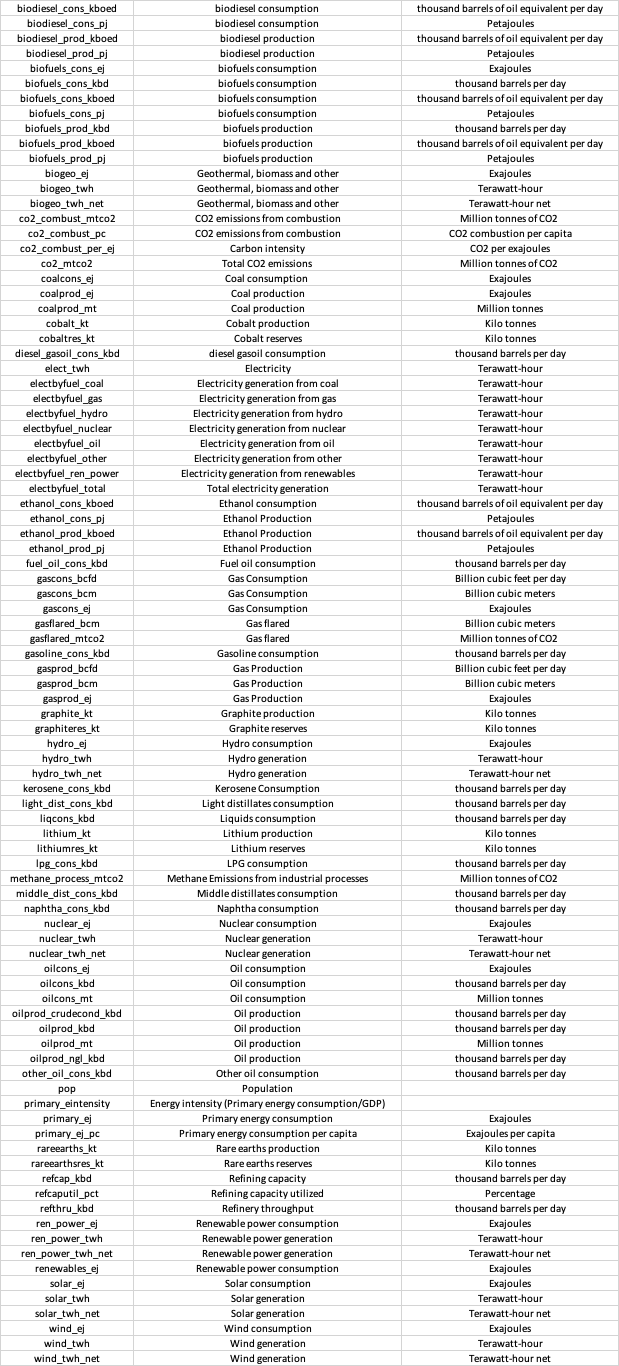

Удалим дублирующиеся колонки (например, колонки с разными единцами измерения для одного и того же параметра или колонки, которые могут давать мультиколлинеарность в данных: это позволит упростить процесс обучения для модели)

In [6]:
columns_to_drop = [
    'ISO3166_numeric',
    'OPEC',
    'EU',
    'OECD',
    'CIS',
    'biodiesel_cons_pj',
    'biodiesel_prod_pj',
    'biofuels_cons_ej',
    'biofuels_cons_pj',
    'biofuels_prod_pj',
    'biogeo_ej',
    'biogeo_twh_net',
    'co2_combust_per_ej',
    'co2_combust_pc',
    'co2_combust_mtco2',
    'coalprod_mt',
    'ethanol_cons_pj',
    'ethanol_prod_pj',
    'gascons_bcm',
    'gascons_ej',
    'gasflared_mtco2',
    'gasprod_bcm',
    'gasprod_ej',
    'hydro_ej',
    'hydro_twh_net',
    'methane_process_mtco2',
    'nuclear_ej',
    'nuclear_twh_net',
    'oilcons_ej',
    'oilcons_mt',
    'oilprod_mt',
    'primary_ej_pc',
    'ren_power_ej',
    'ren_power_twh_net',
    'solar_twh_net',
    'wind_twh_net'
]

data = data.drop(columns=columns_to_drop)

In [7]:
data = data[data['Year'] >= 2007] #Так как данные по нефти Brent у нас есть с 2007 года, то обрежем датафрейм под этот промежуток


In [8]:
#данные в таблице data даны по годам, а в таблице brent - по неделям. Растянем data до недель, чтобы мы могли объединить датафреймы
date_range = []
for year in data['Year']:
    date_range.extend(pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')) #приводим к дням

all_dates_df = pd.DataFrame(date_range, columns=['date'])
df_expanded = all_dates_df.merge(data, left_on=all_dates_df['date'].dt.year, right_on='Year', how='left')
df_expanded.set_index('date', inplace=True)
df_resampled = df_expanded.groupby('Country').resample('W').last() #приводим к неделям, группируя по регионам
df_resampled.drop(columns=['Year'], inplace=True)



In [9]:
brent = brent.reset_index() #перед объединением датафреймов дропнем индекс, чтобы его не потерять

In [10]:
df = df_resampled.merge(brent, left_on = 'date', right_on = 'Date') #склеиваем датафреймы. Brent будет нашим таргетом

In [11]:
df

,Country,pop,biodiesel_cons_kboed,biodiesel_prod_kboed,biofuels_cons_kbd,biofuels_cons_kboed,biofuels_prod_kbd,biofuels_prod_kboed,biogeo_twh,co2_mtco2,...,refthru_kbd,ren_power_twh,renewables_ej,solar_ej,solar_twh,wind_ej,wind_twh,Date,Close,Volume
0,Total Africa,976.461441,NaN,NaN,2.313602,1.279366,1.007612,0.557185,3.199500,1410.952260,...,2354.826303,4.261854,0.048732,0.000469,0.046027,0.010346,1.016326,2007-08-05,75.730000,4117.00
1,Total Africa,976.461441,NaN,NaN,2.313602,1.279366,1.007612,0.557185,3.199500,1410.952260,...,2354.826303,4.261854,0.048732,0.000469,0.046027,0.010346,1.016326,2007-08-12,70.912000,5984.60
2,Total Africa,976.461441,NaN,NaN,2.313602,1.279366,1.007612,0.557185,3.199500,1410.952260,...,2354.826303,4.261854,0.048732,0.000469,0.046027,0.010346,1.016326,2007-08-19,70.518001,3951.80
3,Total Africa,976.461441,NaN,NaN,2.313602,1.279366,1.007612,0.557185,3.199500,1410.952260,...,2354.826303,4.261854,0.048732,0.000469,0.046027,0.010346,1.016326,2007-08-26,69.544000,4109.00
4,Total Africa,976.461441,NaN,NaN,2.313602,1.279366,1.007612,0.557185,3.199500,1410.952260,...,2354.826303,4.261854,0.048732,0.000469,0.046027,0.010346,1.016326,2007-09-02,71.644000,3461.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13707,Total Western Africa,439.868542,NaN,NaN,NaN,NaN,NaN,NaN,0.315116,276.516564,...,NaN,2.699133,0.025916,0.013018,1.392073,0.009276,0.991944,2023-12-03,81.294000,25434.40
13708,Total Western Africa,439.868542,NaN,NaN,NaN,NaN,NaN,NaN,0.315116,276.516564,...,NaN,2.699133,0.025916,0.013018,1.392073,0.009276,0.991944,2023-12-10,75.884000,29122.80
13709,Total Western Africa,439.868542,NaN,NaN,NaN,NaN,NaN,NaN,0.315116,276.516564,...,NaN,2.699133,0.025916,0.013018,1.392073,0.009276,0.991944,2023-12-17,75.338000,25104.00
13710,Total Western Africa,439.868542,NaN,NaN,NaN,NaN,NaN,NaN,0.315116,276.516564,...,NaN,2.699133,0.025916,0.013018,1.392073,0.009276,0.991944,2023-12-24,79.067999,23495.40


In [12]:
df.rename(columns={'Close': 'Brent', 'Volume': 'Brent_Vol'}, inplace=True)

In [13]:
df = df.fillna(0) #предобработаем NaN-ы, заменив их на нули

In [14]:
df = df.set_index('Date')

In [15]:
df = df.sort_index() #отсортируем по дате, чтобы перемешались страны внутри одной даты

## Simple RNN модель

In [16]:
length_data = len(df)
split_ratio = 0.7     # %70 train + %30 validation
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 13712
Train data length : 9598
Validation data lenth : 4114


In [17]:
train_data = df[:length_train] #сплитуем данные по кускам, не перемешивая, так как это временные ряды (для избежания data leakage)

In [18]:
train_data

,Country,pop,biodiesel_cons_kboed,biodiesel_prod_kboed,biofuels_cons_kbd,biofuels_cons_kboed,biofuels_prod_kbd,biofuels_prod_kboed,biogeo_twh,co2_mtco2,...,refcaputil_pct,refthru_kbd,ren_power_twh,renewables_ej,solar_ej,solar_twh,wind_ej,wind_twh,Brent,Brent_Vol
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-05,Total Africa,976.461441,0.000000,0.000000,2.313602,1.279366,1.007612,0.557185,3.199500,1410.952260,...,70.385559,2354.826303,4.261854,0.048732,0.000469,0.046027,0.010346,1.016326,75.7300,4117.00
2007-08-05,Total Non-OPEC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.7300,4117.00
2007-08-05,Total Non-OECD,5463.687155,17.358209,24.581927,373.800033,212.837001,474.253865,270.938496,69.101978,19473.590451,...,78.853333,34989.937677,89.282832,1.438624,0.003059,0.300482,0.202371,19.880372,75.7300,4117.00
2007-08-05,Total OECD,1262.073278,132.454433,126.690438,671.780579,418.289492,624.360345,390.030416,226.143249,14524.853241,...,86.194191,39759.674274,385.274185,5.083789,0.076417,7.507021,1.543446,151.623915,75.7300,4117.00
2007-08-05,Total Middle East,205.935379,0.000000,0.000000,0.259450,0.143470,0.000000,0.000000,0.010000,1946.895227,...,84.802986,6514.565427,0.165100,0.002014,0.000001,0.000100,0.001578,0.155000,75.7300,4117.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-27,Total Europe,676.037675,273.967880,261.860349,429.716881,334.446733,404.757919,316.379007,225.324933,4299.382486,...,81.001610,12699.192465,835.805601,9.078109,1.432806,150.988534,4.360351,459.492134,61.3425,38772.25
2019-01-27,Total EU,445.026985,237.464075,249.617058,366.769539,286.737472,382.551843,299.772650,166.514935,3052.941128,...,82.695129,10541.931716,654.943221,7.173207,1.176460,123.974923,3.458480,364.453363,61.3425,38772.25
2019-01-27,Total Central America,49.715467,0.000000,0.000000,1.001000,0.000000,0.000000,0.000000,10.161045,84.472400,...,0.000000,0.000000,16.842228,0.171094,0.021635,2.279923,0.041766,4.401260,61.3425,38772.25


In [19]:
validation_data = df[length_train:]

In [20]:
cat_features = ['Country'] #это единственная категориальная переменная датафрейма
num_features = [col for col in train_data.columns if col not in cat_features] #это остальные столбцы
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data[num_features])  # Обучаем на оригинальном датафрейме

# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(feature_range=(0, 1)), num_features),  # Используем MinMaxScaler здесь
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ]
)

In [21]:
dataset_train_scaled = preprocessor.fit_transform(train_data) #фиттим и обрабатываем тренировочные данные

In [22]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
feature_names = num_features + ohe_feature_names.tolist()

df_processed_train = pd.DataFrame(dataset_train_scaled, columns=feature_names)
#здесь мы создаем новый датафрейм, куда передаем отмасштабированные значения, чтобы понять, какой по счету будет таргет-переменная

In [23]:
length_train = dataset_train_scaled.shape[0]

X_train = []
y_train = []
# создадим временное окно для скольжения данных: оно будет равно 30 неделям. Каждая последующая неделя из предсказанных значений будет добавлена в обучающую выборку.
time_step = 30
for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i, :])
    y_train.append(dataset_train_scaled[i, -18]) #таргет-переменная 18-ая по счету

X_train, y_train = np.array(X_train), np.array(y_train)

In [24]:
X_train.shape #проверяем, что тренировочные данные имеют размерность (num_samples, timesteps, num_features)

(9568, 30, 78)

In [25]:
y_train.shape

(9568,)

In [26]:
y_train = np.reshape(y_train, (y_train.shape[0],1)) #сделаем из тренировочного таргета двумерный массив

print("Shape of y_train after reshape :",y_train.shape)

Shape of y_train after reshape : (9568, 1)


In [27]:
# Параметры модели
time_steps = 30
number_feat = 78

In [28]:

# Создание последовательной модели
regressor = Sequential()

# Добавление первого слоя RNN с регуляризацией Dropout
regressor.add(
    SimpleRNN(units=50,  # Количество нейронов в слое
              activation="tanh",  # Активационная функция
              return_sequences=True,  # Возвращать последовательности для следующего слоя
              input_shape=(X_train.shape[1], number_feat))  # Форма входных данных
)

regressor.add(Dropout(0.2))  # Применение Dropout для предотвращения переобучения

# Добавление второго слоя RNN с регуляризацией Dropout
regressor.add(
    SimpleRNN(units=10,  # Количество нейронов в слое
              activation="tanh",  # Активационная функция
              return_sequences=True)  # Возвращать последовательности для следующего слоя
)

regressor.add(Dropout(0.2))  # Применение Dropout для предотвращения переобучения

# Добавление третьего слоя RNN с регуляризацией Dropout
regressor.add(
    SimpleRNN(units=10,  # Количество нейронов в слое
              activation="tanh",  # Активационная функция
              return_sequences=True)  # Возвращать последовательности для следующего слоя
)

regressor.add(Dropout(0.2))  # Применение Dropout для предотвращения переобучения

# Добавление четвертого слоя RNN без возвращения последовательностей
regressor.add(
    SimpleRNN(units=10)  # Количество нейронов в слое
)

regressor.add(Dropout(0.2))  # Применение Dropout для предотвращения переобучения

# Добавление выходного слоя для регрессии
regressor.add(Dense(units=1))  # Один нейрон на выходе, так как задача регрессии

# Компиляция модели с оптимизатором Adam и функцией потерь MSE (среднеквадратичная ошибка)
regressor.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Обучение модели на тренировочных данных с заданным количеством эпох и размером батча
history = regressor.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.6347 - mae: 0.6233
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.1811 - mae: 0.3372
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0907 - mae: 0.2369
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0497 - mae: 0.1747
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0282 - mae: 0.1313
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0175 - mae: 0.1037
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0122 - mae: 0.0864
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0087 - mae: 0.0723
Epoch 9/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0064 - mae: 0.0623
Epoch 10/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0051 - mae: 0.0554


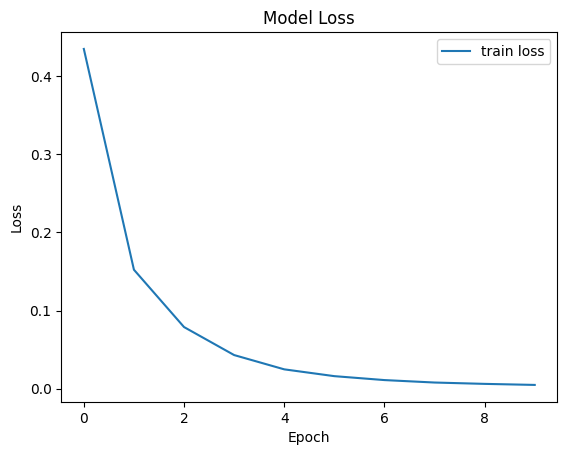

In [29]:
#Проиллюстрируем зависимость значения функции потерь от эпохи

plt.plot(history.history['loss'], label='train loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

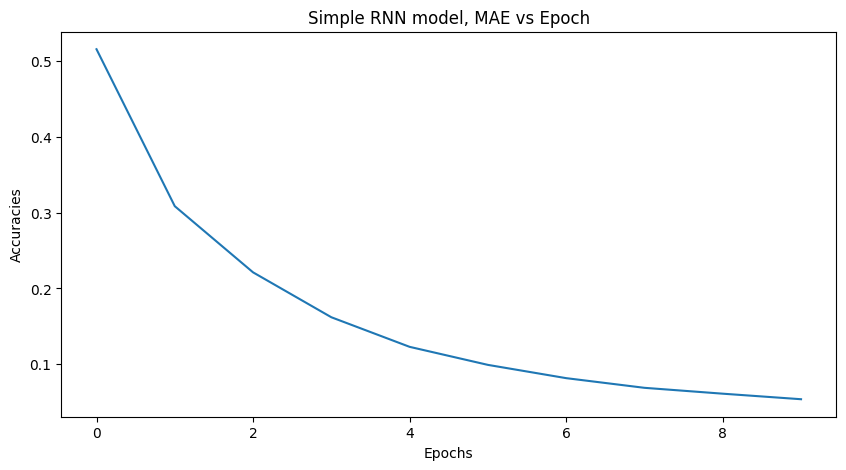

In [30]:
#Проиллюстрируем зависимость значения функции MAE от эпохи
plt.figure(figsize =(10,5))
plt.plot(history.history["mae"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, MAE vs Epoch")
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


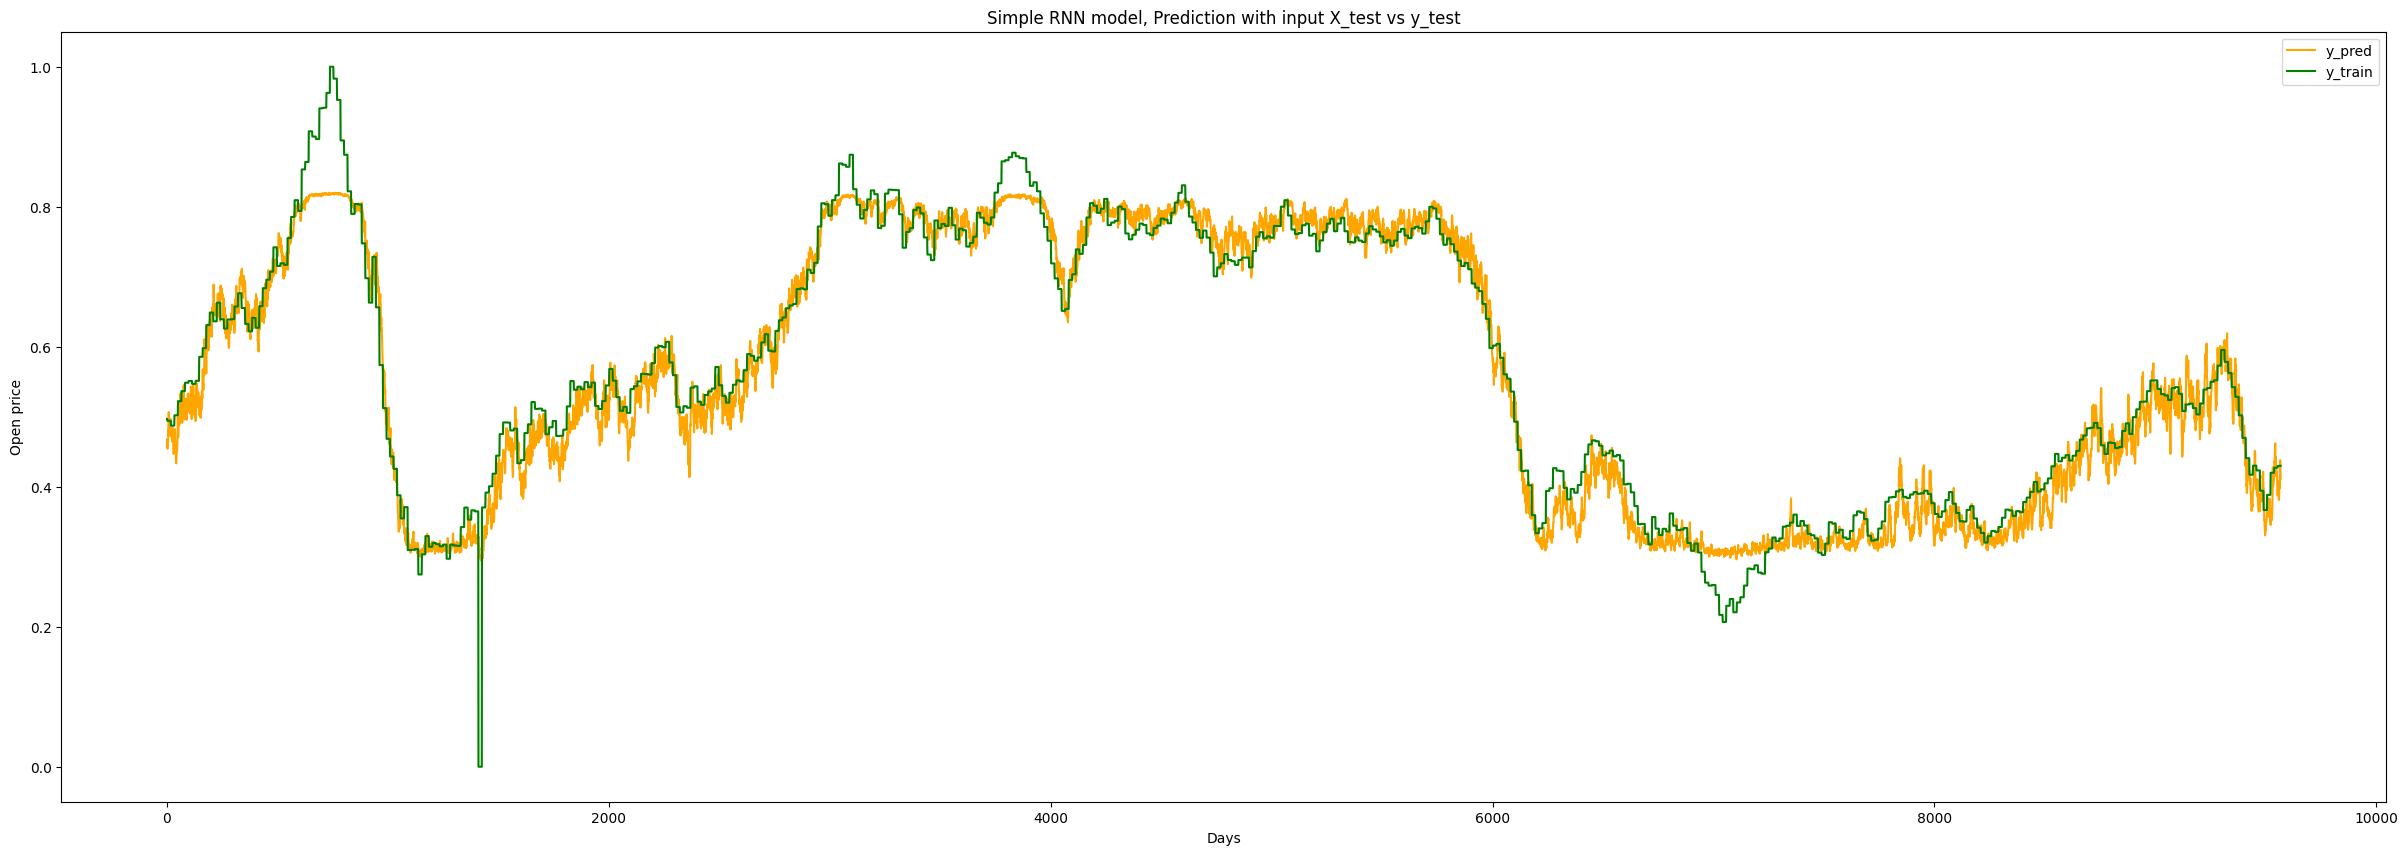

In [31]:
y_pred = regressor.predict(X_train)  #посмотрим на предсказания на тренировочной выборке еще до обратного скейлинга данных


plt.figure(figsize = (30,10))
plt.plot(y_pred, label = "y_pred", c = "orange")
plt.plot(y_train, label = "y_train", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [32]:
dataset_test_scaled = preprocessor.transform(validation_data) #берем обученный трансформер и предобрабатываем тестовые данные

In [33]:
length_test = dataset_test_scaled.shape[0]

X_test = []
y_test = []

time_step = 30
for i in range(time_step, length_test):
    X_test.append(dataset_test_scaled[i-time_step:i, :])
    y_test.append(dataset_test_scaled[i, -18])

X_test, y_test = np.array(X_test), np.array(y_test)

In [34]:
#точно так же проверяем датафрейм

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
feature_names = num_features + ohe_feature_names.tolist()

df_processed_test = pd.DataFrame(dataset_test_scaled, columns=feature_names)

In [35]:
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("Shape of y_train after reshape :",y_test.shape)

Shape of y_train after reshape : (4084, 1)


In [36]:
y_pred_of_test = regressor.predict(X_test)
#получаем значения
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Shape of y_pred_of_test : (4084, 1)


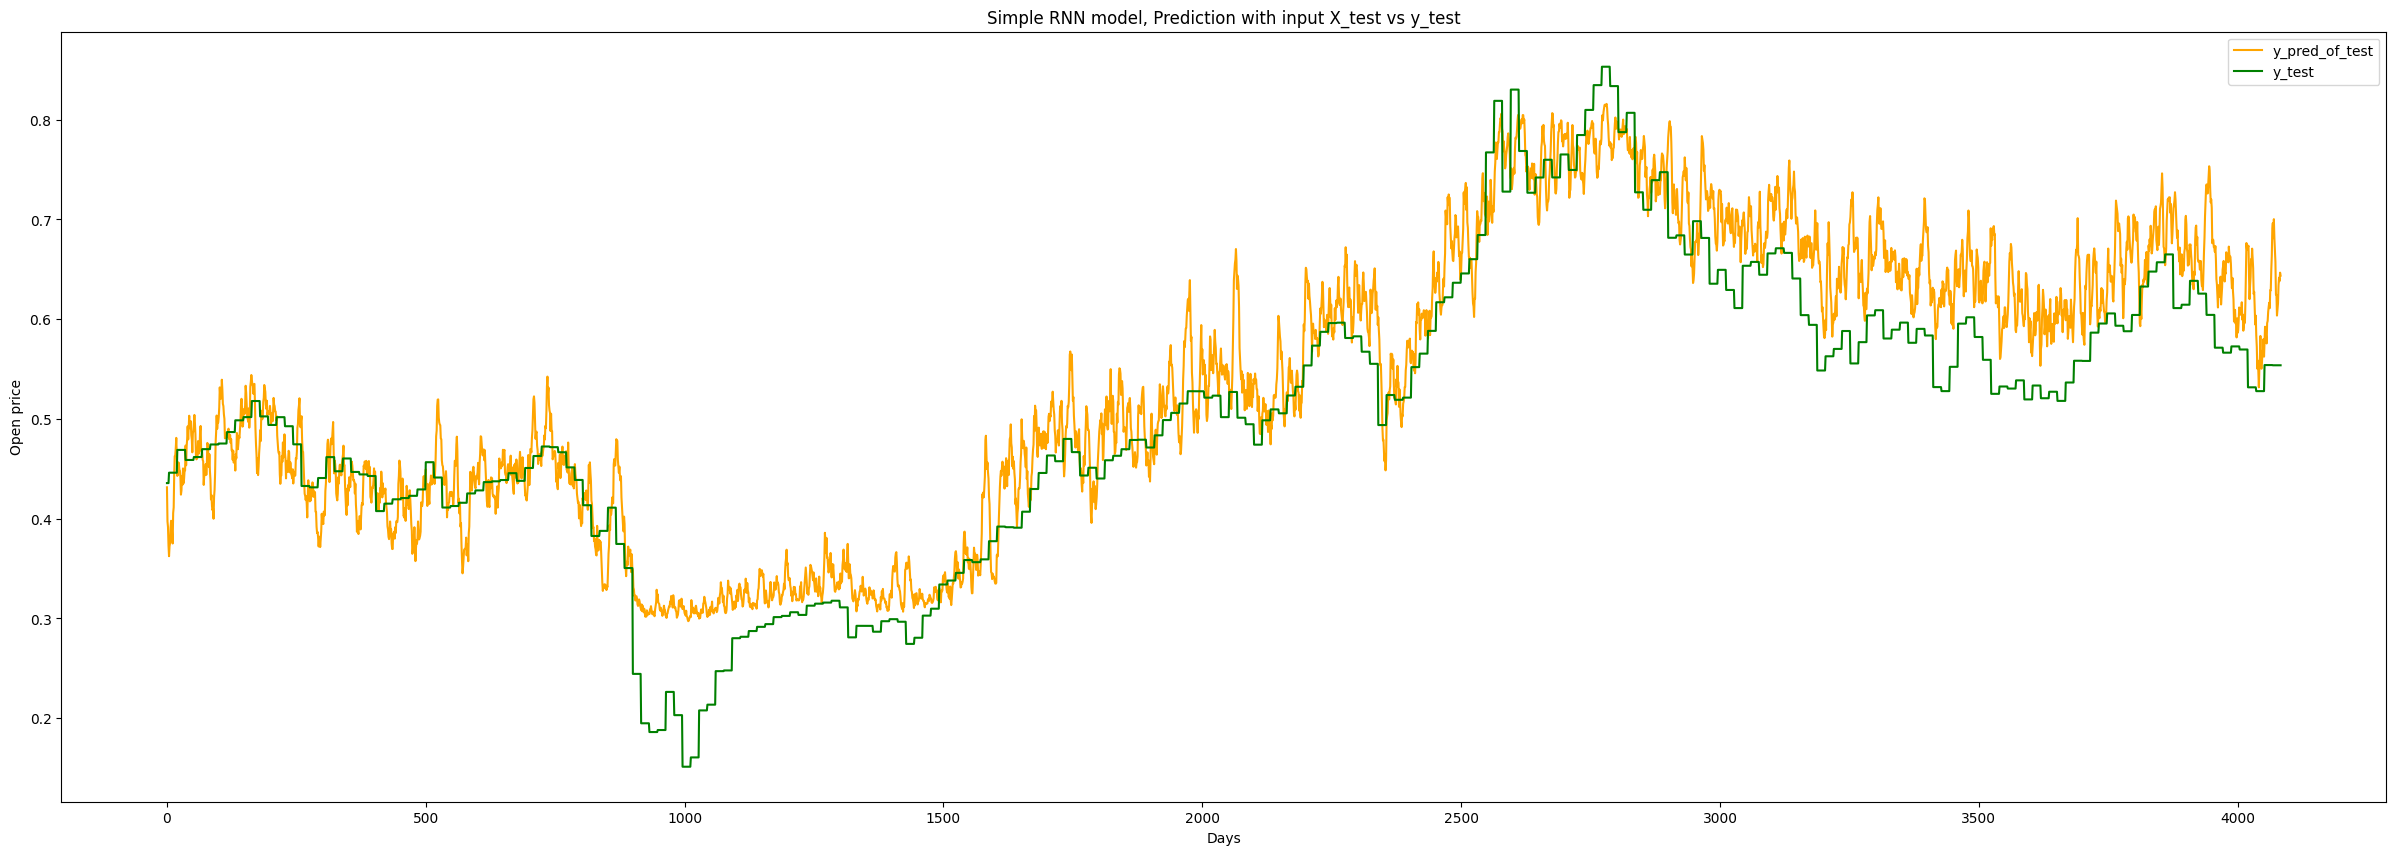

In [37]:
#проиллюстрируем качество прогноза на тестовых данных
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(y_test, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

## LSTM модель

In [38]:
from keras.layers import LSTM
timesteps = 30  # Количество временных шагов в окне
num_features = 78  # Количество признаков

# Создание последовательной модели LSTM
model_lstm = Sequential()

# Добавление первого слоя LSTM с возвращением последовательностей
model_lstm.add(
    LSTM(64,  # Количество нейронов в блоке LSTM
         return_sequences=True,  # Возвращать последовательности для следующего слоя
         input_shape=(timesteps, num_features))  # Форма входных данных
)

# Добавление второго слоя LSTM без возвращения последовательностей
model_lstm.add(
    LSTM(64,  # Количество нейронов в блоке LSTM
         return_sequences=False)  # Не возвращать последовательности, так как это последний слой LSTM
)

# Добавление полносвязного слоя с 32 нейронами
model_lstm.add(Dense(32))  # Полносвязный слой для обработки выходных данных из предыдущего слоя
# Добавление выходного слоя для регрессии
model_lstm.add(Dense(1))  # Один нейрон на выходе, так как задача регрессии

# Компиляция модели с функцией потерь MSE и оптимизатором Adam
model_lstm.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])  # Метрики остаются прежними

# Обучение модели на тренировочных данных с заданным количеством эпох и размером батча
history2 = model_lstm.fit(X_train, y_train, epochs=3, batch_size=10)

Epoch 1/3
957/957 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - loss: 0.0060 - mae: 0.0388
Epoch 2/3
957/957 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 5.3371e-04 - mae: 0.0156
Epoch 3/3
957/957 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 3.1542e-04 - mae: 0.0125


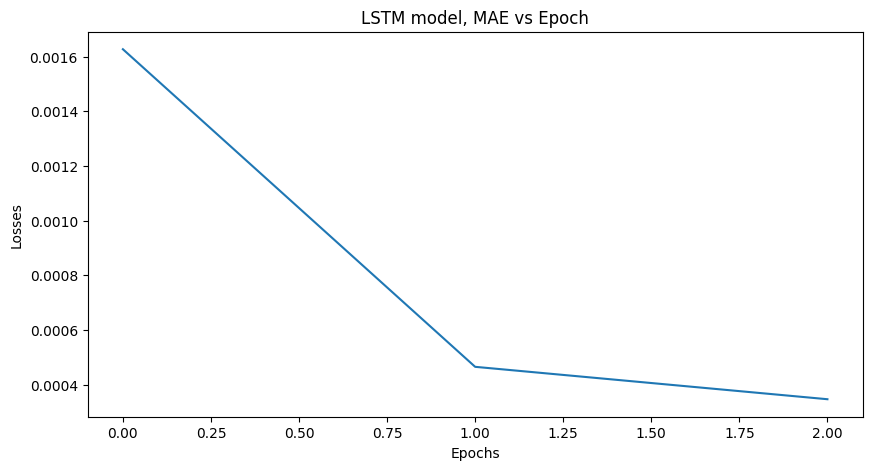

In [39]:
#посмотрим на зависимость функции потерь от эпохи
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, MAE vs Epoch")
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


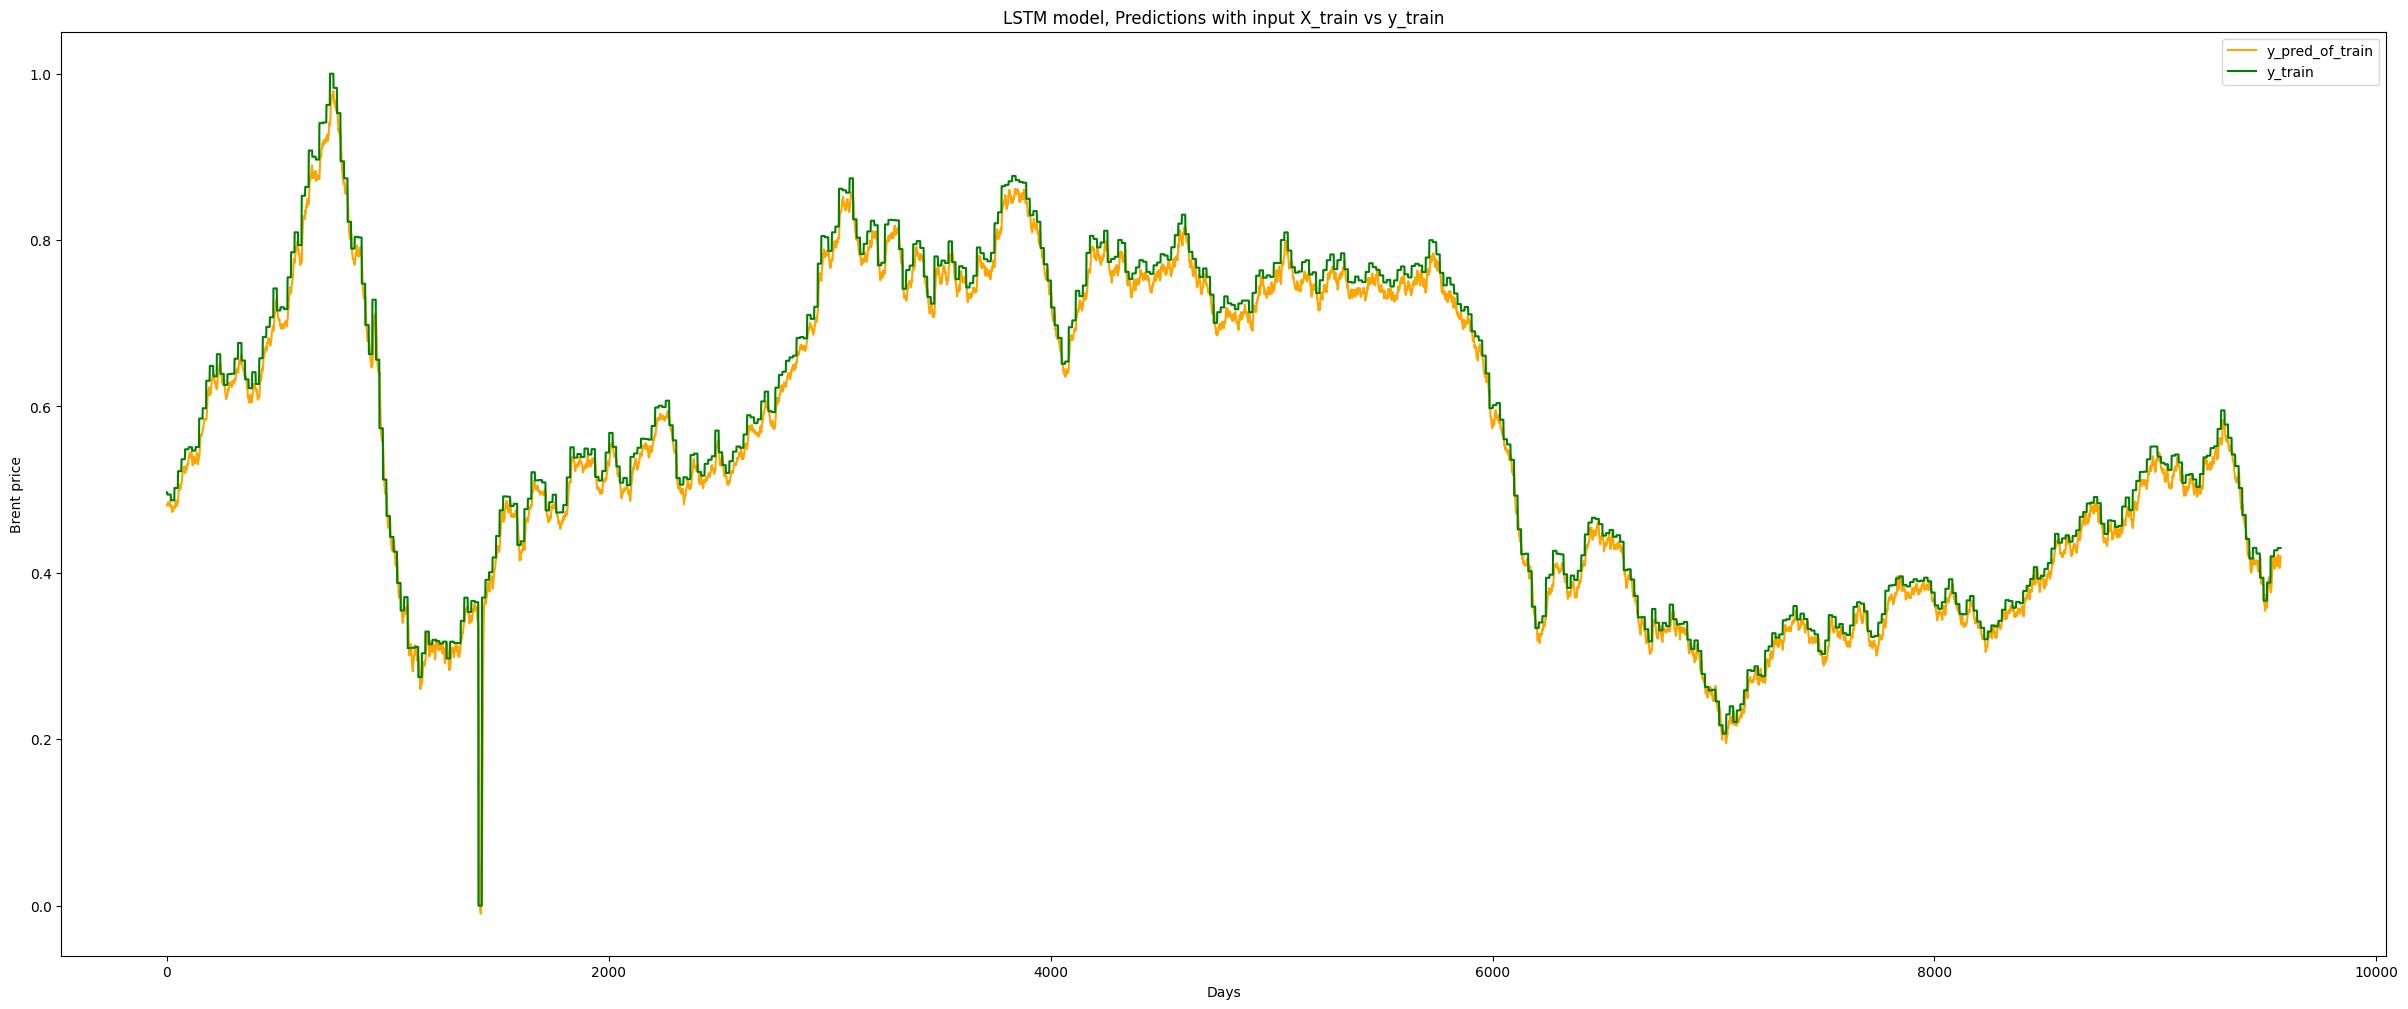

In [40]:
#проиллюстрируем качество предсказаний на тренировочной выборке до обратного скейлинга данных
y_train_pred = model_lstm.predict(X_train)
plt.subplots(figsize=(30, 12))
plt.plot(y_train_pred, label="y_pred_of_train", color="orange")
plt.plot(y_train, label="y_train", color="g")
plt.xlabel("Days")
plt.ylabel("Brent price")
plt.title("LSTM model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


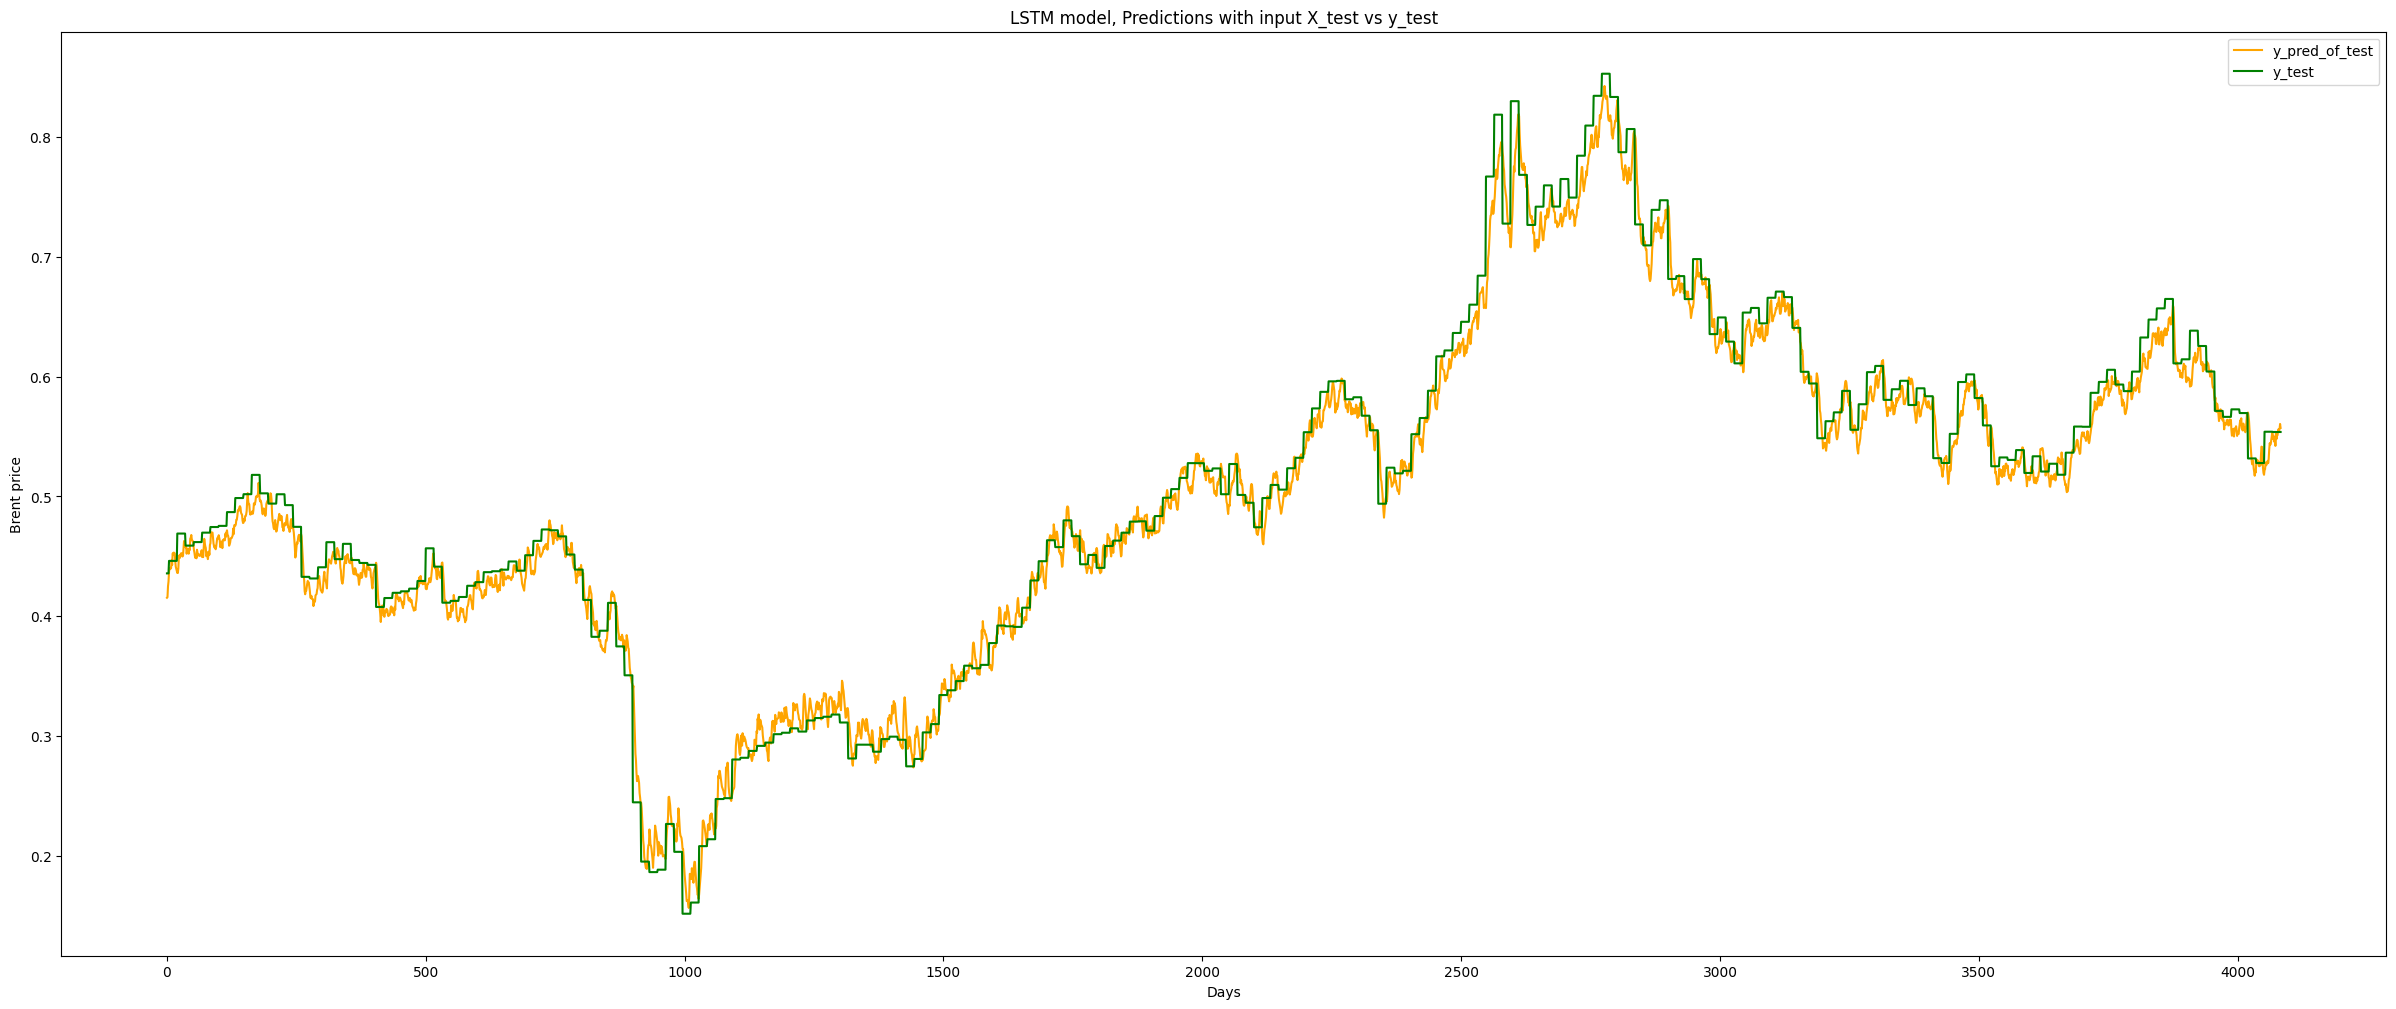

In [41]:
#проиллюстрируем качество предсказаний на тестовой выборке до обратного скейлинга данных
plt.subplots(figsize =(30,12))
plt.plot((model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot((y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Brent price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

In [42]:
#в numpy достаточно сложно обратно масштабировать данные, если они были в виде датафрейма. Поэтому проще руками написать функцию, которая бы это сделала для отдельного интересующего нас вектора.
def denormalize(X_scaled, min_val, max_val):
    """
    Обратное преобразование для восстановления значения X.

    :param X_scaled: Отмасштабированное значение
    :param min_val: Минимальное значение исходных данных
    :param max_val: Максимальное значение исходных данных
    :return: Восстановленное значение X
    """
    X = X_scaled * (max_val - min_val) + min_val
    return X

In [43]:
min = train_data['Brent'].min() #минимумы и максимумы для функции
max = train_data['Brent'].max()

In [44]:
y_test = denormalize(y_test, min, max)

In [45]:
y_pred_lstm = denormalize(model_lstm.predict(X_test), min, max) #для модели LSTM

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [46]:
y_pred_rnn = denormalize(y_pred_of_test, min, max) #для модели RNN

### LSTM

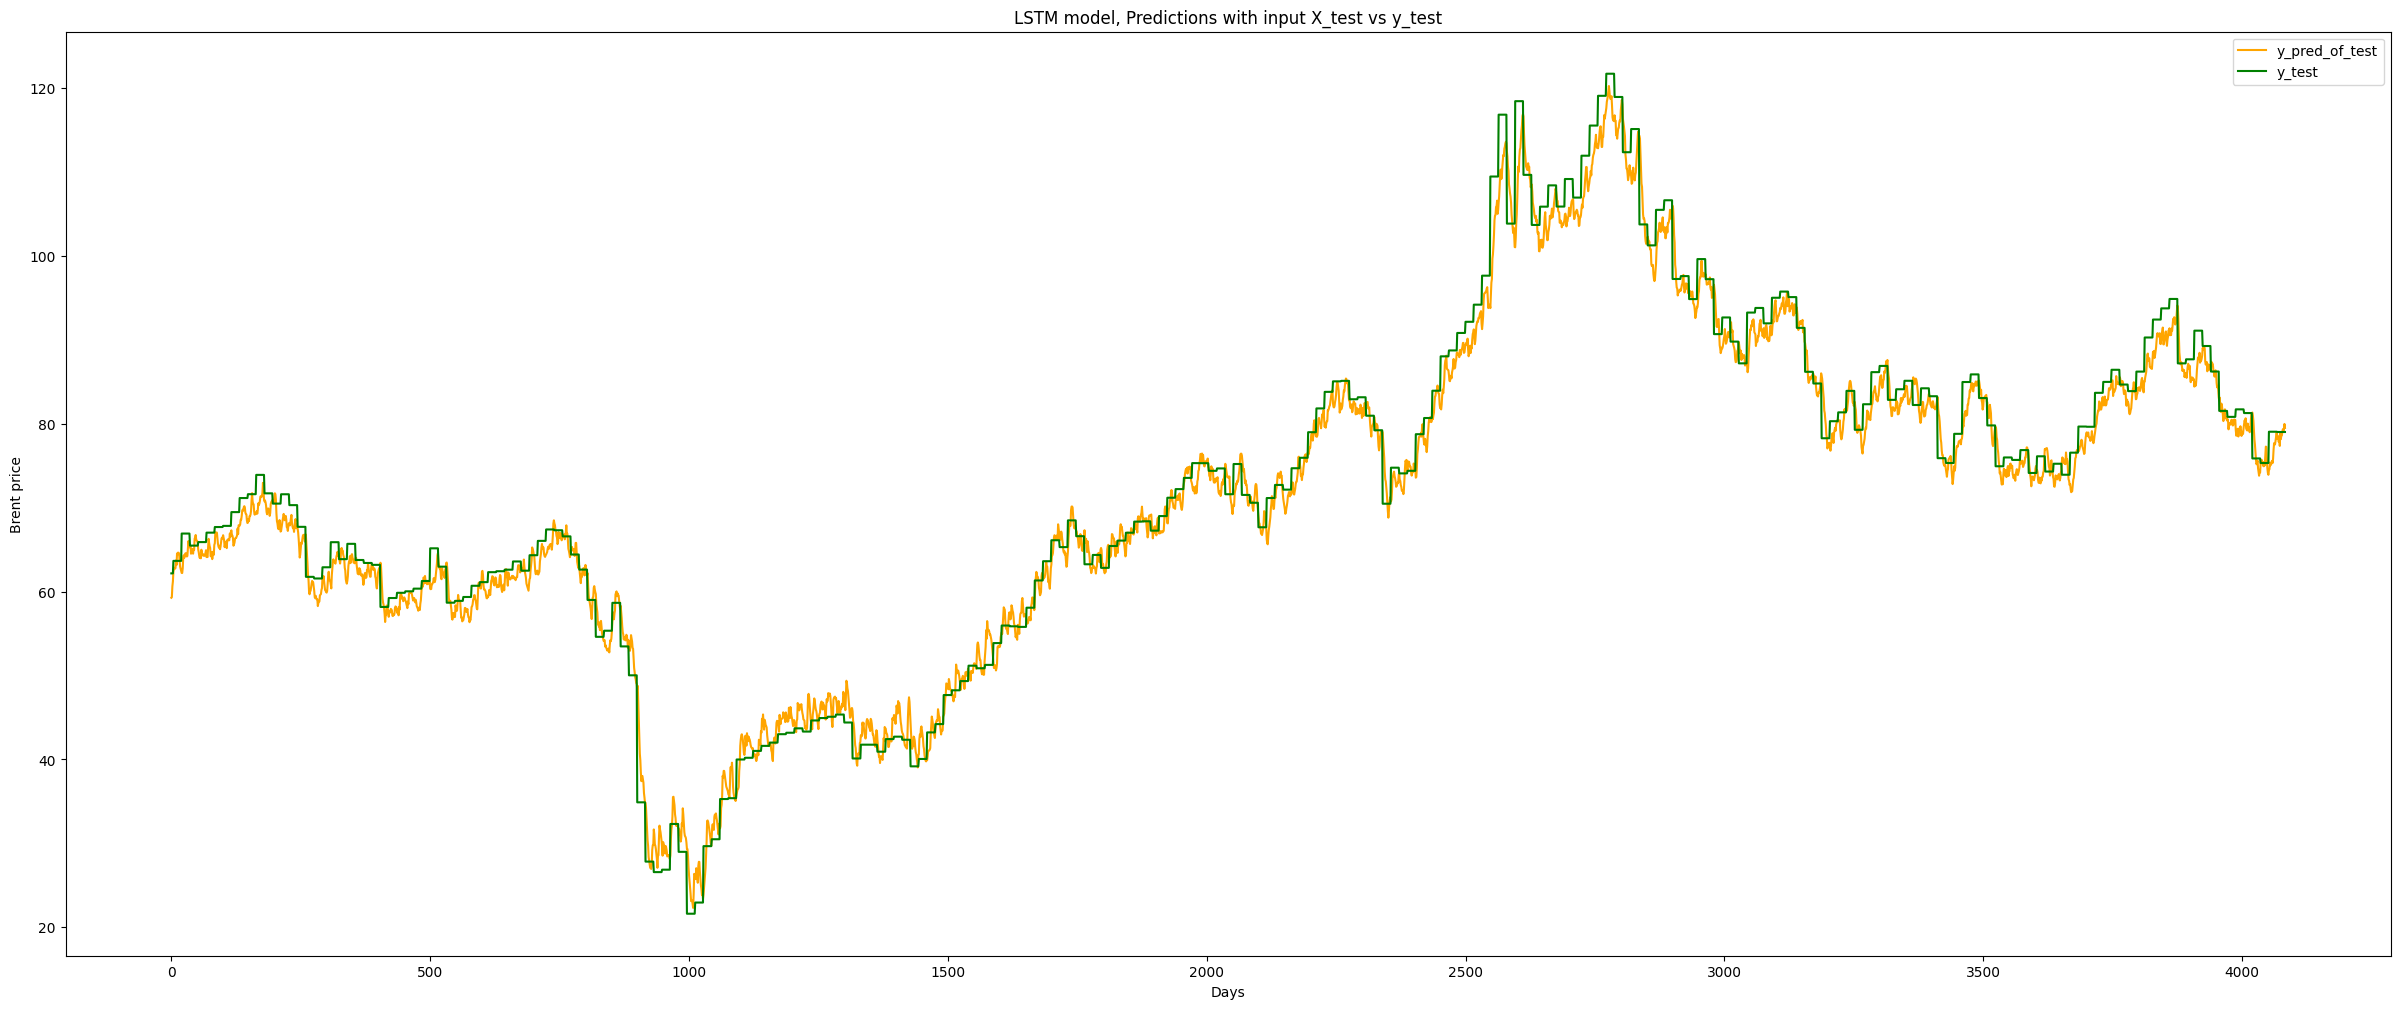

In [47]:
#проиллюстрируем качество предсказаний на тестовой выборке со значениями до преобразований
plt.subplots(figsize =(30,12))
plt.plot(y_pred_lstm, label = "y_pred_of_test", c = "orange" )
plt.plot((y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Brent price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

### RNN


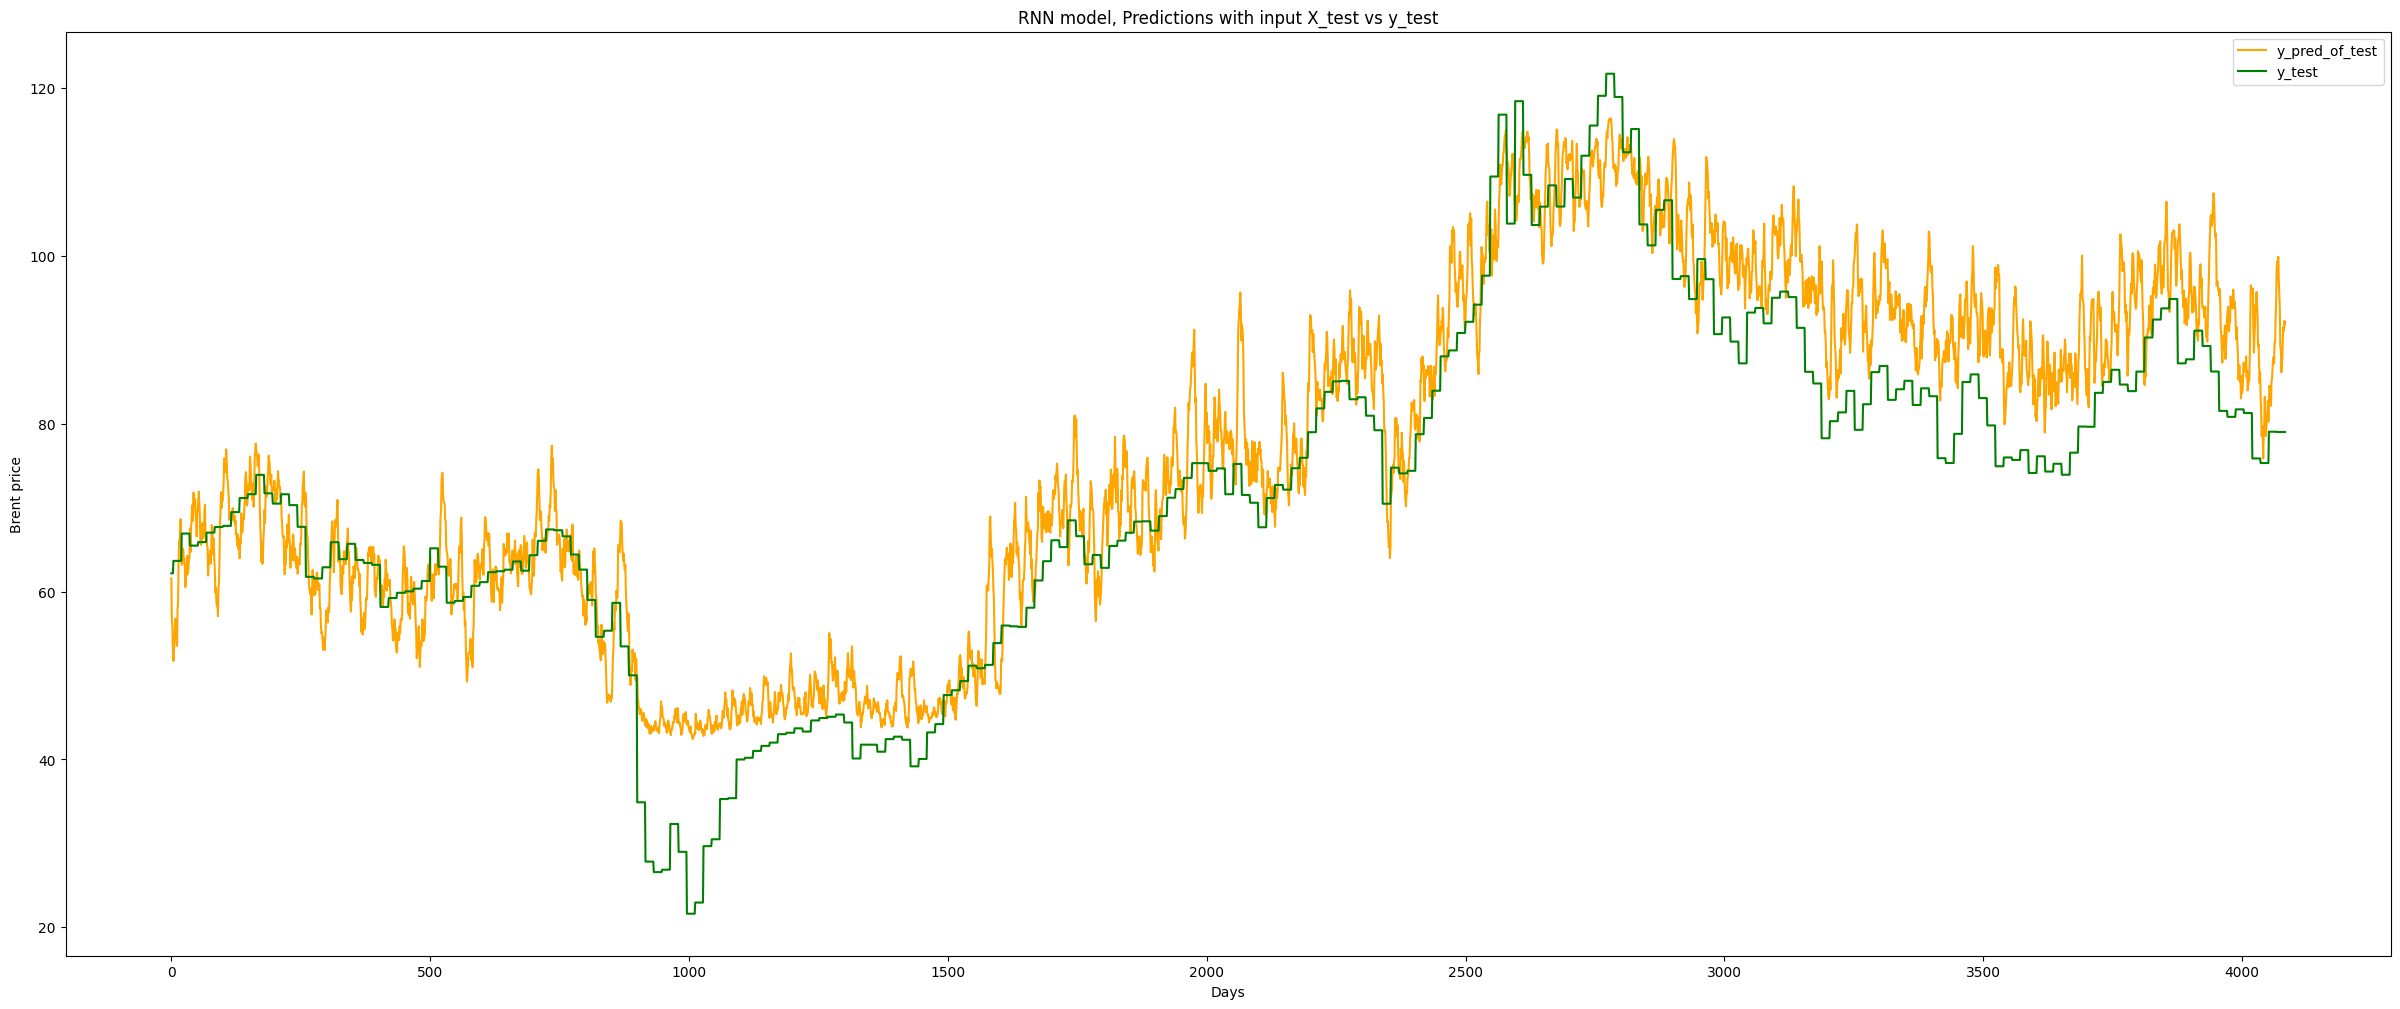

In [48]:
#проиллюстрируем качество предсказаний на тестовой выборке со значениями до преобразований
plt.subplots(figsize =(30,12))
plt.plot(y_pred_rnn, label = "y_pred_of_test", c = "orange" )
plt.plot((y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Brent price")
plt.title("RNN model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

Как мы видим из графика, а также метрик качества, LSTM более продуктивна для использования в целях прогнозирования цен на нефть, что, однако, может компенсироваться разницей в скорости обучения моделей на больших объемах данных.

## LSTM for long-term forecasting

Предложенная модель LSTM действительно хороша в прогнозировании, однако, она может прогнозировать лишь на 1 шаг вперед. Для долгосрочного прогнозирования нам потребуется переделать внешний слой нейронной сети, чтобы она на выходе возвращала 200 прогнозных единиц за раз.

In [61]:
length_train = dataset_train_scaled.shape[0]

X_train = []
y_train = []
time_step = 30
forecast_horizon = 200  # Количество предсказываемых значений

for i in range(time_step, length_train - forecast_horizon + 1):
    X_train.append(dataset_train_scaled[i-time_step:i, :])  # Временное окно
    y_target = dataset_train_scaled[i:i + forecast_horizon, -18]  # Следующие 200 значений
    y_train.append(y_target)

X_train = np.array(X_train)
y_train = np.array(y_train)



In [65]:
timesteps = 30  # Количество временных шагов в окне
num_features = 78  # Количество признаков

# Создание последовательной модели LSTM
model_lstm = Sequential()

# Первый слой LSTM с возвращением последовательностей
model_lstm.add(
    LSTM(64,
         return_sequences=True,
         input_shape=(timesteps, num_features))
)

# Второй слой LSTM без возвращения последовательностей
model_lstm.add(
    LSTM(64,
         return_sequences=False)
)

# Полносвязный слой для обработки выходных данных из предыдущего слоя
model_lstm.add(Dense(32))

# Изменение выходного слоя для регрессии на 200 значений
model_lstm.add(Dense(200))  # Теперь один нейрон на каждое из 200 предсказанных значений

# Компиляция модели с функцией потерь MSE и оптимизатором Adam
model_lstm.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])

# Обучение модели на тренировочных данных с заданным количеством эпох и размером батча
history2 = model_lstm.fit(X_train, y_train, epochs=3, batch_size=10)

Epoch 1/3
937/937 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.0360 - mae: 0.1094
Epoch 2/3
937/937 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 0.0050 - mae: 0.0494
Epoch 3/3
937/937 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - loss: 0.0047 - mae: 0.0478


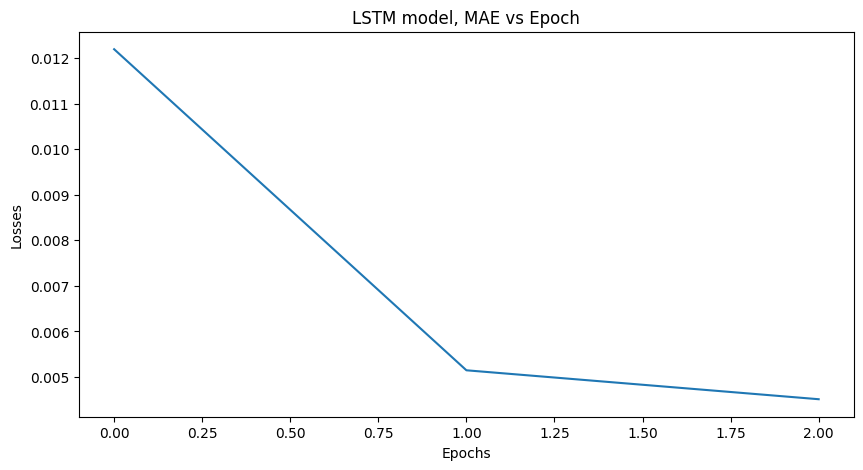

In [66]:
#посмотрим на зависимость функции потерь от эпохи
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, MAE vs Epoch")
plt.show()

In [68]:
last_steps = dataset_test_scaled[-time_step:, :]  # Последние 30 шагов
last_steps = last_steps.reshape((1, time_step, num_features))  # Изменение формы для модели

# Выполнение предсказания
predicted_values = model_lstm.predict(last_steps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [70]:
predicted_values = np.array(predicted_values)

In [72]:
predicted_values = denormalize(predicted_values, min, max)

In [80]:
predicted_values

array([[91.91656 , 92.39443 , 91.044556, 91.31893 , 90.72912 , 91.76927 ,
        92.47895 , 88.661255, 89.47025 , 91.74676 , 91.20303 , 91.16802 ,
        91.96349 , 91.704094, 91.55463 , 89.348076, 90.18739 , 89.28507 ,
        90.279564, 91.3383  , 91.058846, 89.46063 , 91.93987 , 92.45156 ,
        92.81571 , 90.22655 , 91.31588 , 91.12003 , 91.38756 , 89.252106,
        90.43656 , 93.57625 , 92.209625, 91.495995, 92.4796  , 91.2121  ,
        91.52361 , 89.451385, 91.61678 , 91.26112 , 90.40651 , 90.75516 ,
        91.258965, 91.26162 , 89.52089 , 89.54372 , 92.6165  , 87.93112 ,
        91.7974  , 89.74154 , 90.42777 , 89.878235, 91.43613 , 90.77797 ,
        90.4415  , 91.06432 , 91.450935, 90.421555, 91.93833 , 91.41032 ,
        91.56769 , 91.136116, 90.65306 , 91.575165, 89.999176, 91.15666 ,
        91.05586 , 90.49366 , 91.69488 , 91.03935 , 93.59331 , 90.05314 ,
        90.44861 , 91.10851 , 92.74866 , 91.64864 , 89.93352 , 91.08565 ,
        89.746056, 89.86554 , 89.8924 

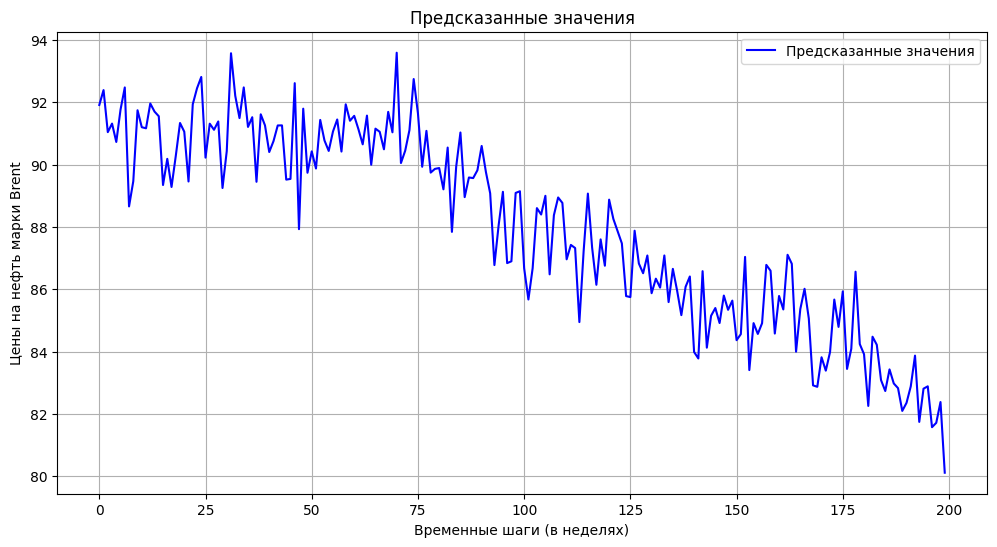

In [82]:
predicted_values = predicted_values.flatten()

# Создание временных меток для предсказанных значений
time_steps = np.arange(len(predicted_values))

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(time_steps, predicted_values, label='Предсказанные значения', color='blue')
plt.title('Предсказанные значения')
plt.xlabel('Временные шаги (в неделях)')
plt.ylabel('Цены на нефть марки Brent')
plt.legend()
plt.grid()
